# LGBM - New Feature + Baseline Rolling Window

In [60]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from utils import *
import sys
import xgboost as xgb
import lightgbm as lgb
from datetime import datetime
from jupyterthemes import jtplot

jtplot.style(theme='grade3')
plt.rcParams['figure.figsize'] = (12, 10.0) # set default size of plots

NUMBER_OF_LAGS = 4

sys.path.append("../../main/datasets/")
!ls  ../../main/datasets/

1.0v.zip


<hr>

## Defining metrics

Baseline_score function

In [2]:
def baseline_score(prediction, target, simulatedPrice):
    prediction = prediction.astype(int)

    return np.sum((prediction - np.maximum(prediction - target, 0) * 1.6)  * simulatedPrice)

Evaluation Metric

In [3]:
def feval(prediction, dtrain):
    
    prediction = prediction.astype(int)
    target = dtrain.get_label()

    simulatedPrice = dtrain.get_weight()
    
    return 'feval', np.sum((prediction - np.maximum(prediction - target, 0) * 1.6)  * simulatedPrice), True

<hr>

## Building our dataset
This notebook makes this step cleaner than the previous versions. So It'll be tidier and shorter than before!

In [4]:
infos, items, orders = read_data("../../main/datasets/")
print("Sanity checks...", infos.shape, items.shape, orders.shape)

Sanity checks... (10463, 3) (10463, 8) (2181955, 5)


In [5]:
# Changing our time signatures
process_time(orders)

In [6]:
df = dataset_builder(orders, items)

<hr>

## Feature building

**Adding 'is_new'**

In [7]:
# This cell adds a feature responsible for indicating if in the current week
# a given item has its first appearance.
orders_sorted_by_week = orders.sort_values('group_backwards', ascending=False)
weeks_grouped_by_items = orders_sorted_by_week.groupby('itemID', as_index=False)
items_first_appearance = weeks_grouped_by_items.first()[['itemID', 'group_backwards']]

items_first_appearance.rename(columns={'group_backwards':'first_appearance'}, inplace=True)

df['is_new'] = 0

df = pd.merge(df, items_first_appearance, left_on=['itemID'], right_on=['itemID'], how='left', validate='m:1')

df.loc[df['first_appearance'] == df['group_backwards'], 'is_new'] = 1
df.drop(columns=['first_appearance'], inplace=True)

**Cumulative sale by category**

In [8]:
# percentage_accum_cat_3 feature...
df = cumulative_sale_by_category(df, category='category3')

**Time Encoding**

In [9]:
# Encoding our weeks as a series of sines and cosines...
# This function will consider our period as a semester in a year,
# so we can try other types of time encoding later!
df = time_encoder(df, 'group_backwards', 26)

**Lags and diffs**

In [10]:
# This cell lags and diffs our feature 'orderSum'
shifting = df.copy()

for i in range(1, NUMBER_OF_LAGS + 1):
    # Carrying the data of weeks t-1
    shifting[f'orderSum_{i}'] = shifting.groupby('itemID')['orderSum'].shift(i)

    
    # Getting the difference of the orders and promotions between weeks t-1 and t-2...
    shifting[f'orderSum_diff_{i}'] = shifting.groupby('itemID')[f'orderSum_{i}'].diff()
    

**Rolling window "orderSum"**

In [11]:
%%time
# This cell creates rolling-window features based on 'orderSum' in our dataset!
item_group = shifting.groupby(["itemID", "group_backwards"]).agg({'orderSum':'sum'})

# We'll .shift(-1) because it sorts our "group_backwards", 
# so doing .shift(1) would cause a HUGE dataleak.
aux_shifting = item_group.groupby('itemID')[['orderSum']].shift(-1)

aux_shifting.sort_values(['itemID', 'group_backwards'], ascending=[True, False], inplace=True)

for i in range(3):
    rolled_window = aux_shifting.groupby(['itemID'], as_index=False)[['orderSum']].rolling(2 ** i).mean()
    rolled_window.rename(columns={'orderSum':f"orderSum_mean_rolled_{i}"}, inplace=True)
    shifting = pd.merge(shifting, rolled_window, left_on=['itemID', 'group_backwards'], right_on=['itemID', 'group_backwards'])

CPU times: user 42.1 s, sys: 214 ms, total: 42.3 s
Wall time: 42.4 s


In [12]:
# LGBM Says on docs that it automatically handles zero values as NaN,
# so we'll keep this standard...
shifting.fillna(0, inplace=True)

<hr>

## Maximum error
The maximum error we could get in this dataset would be just guessing the mean of our sales from weeks 1 to 12, and that's what the cell below is computing.

In [13]:
worst_possible_prediction = shifting.loc[shifting.group_backwards > 1]['orderSum'].mean()
prediction = np.full(shifting.loc[shifting.group_backwards == 1]['orderSum'].shape, worst_possible_prediction) # Array filled with the mean...
target = shifting.loc[shifting.group_backwards == 1]['orderSum']
print("Guessing the mean of 'orderSum' for all items in target", mse(target, prediction) ** 0.5)

Guessing the mean of 'orderSum' for all items in target 118.20105838913783


<hr>

## Dataset Splitting (Train until week 3 / Val. week 2/ Test week 1)
All my experiments will use weeks 13 to 3 as a train set, week 2 as our validation set and week 1 as a test set.

In [14]:
train = shifting.loc[shifting.group_backwards >= 5]
val_week_4 = shifting.loc[shifting.group_backwards == 4]
val_week_3 = shifting.loc[shifting.group_backwards == 3]
val_week_2 = shifting.loc[shifting.group_backwards == 2]
test = shifting.loc[shifting.group_backwards == 1]

weights = infos.set_index('itemID')['simulationPrice'].to_dict()

w_train = train['itemID'].map(weights)
w_val_week_4 = val_week_4['itemID'].map(weights)
w_val_week_3 = val_week_3['itemID'].map(weights)
w_val_week_2 = val_week_2['itemID'].map(weights)

In [15]:
# I recommend to the other members of the team keeping the
# datatypes of our datasets as Pandas DataFrames instead of Numpy,
# since It will easier to use Boosting Analysis frameworks
y_train = train['orderSum']
y_val_week_4 = val_week_4['orderSum']
y_val_week_3 = val_week_3['orderSum']
y_val_week_2 = val_week_2['orderSum']
X_train = train.drop(columns=["orderSum"])
X_val_week_4 = val_week_4.drop(columns=["orderSum"])
X_val_week_3 = val_week_3.drop(columns=["orderSum"])
X_val_week_2 = val_week_2.drop(columns=["orderSum"])

In [16]:
params = {
#           "objective" : "poisson",
          "objective" : "l1",
          "metric" :"rmse",
          "learning_rate" : 0.5,
          'verbosity': 1,
          'max_depth': 6,
          'num_leaves': 32,
          "min_data_in_leaf":3000,
         }

lgbtrain = lgb.Dataset(X_train, label = y_train, weight=w_train, categorical_feature=[2, 3, 5, 6, 7, 9])
lgbvalid_week_4 = lgb.Dataset(X_val_week_4, label = y_val_week_4, weight=w_val_week_4, categorical_feature=[2, 3, 5, 6, 7, 9])
lgbvalid_week_3 = lgb.Dataset(X_val_week_3, label = y_val_week_3, weight=w_val_week_3, categorical_feature=[2, 3, 5, 6, 7, 9])
lgbvalid_week_2 = lgb.Dataset(X_val_week_2, label = y_val_week_2, weight=w_val_week_2, categorical_feature=[2, 3, 5, 6, 7, 9])

num_round = 1000
model = lgb.train(params,
                  lgbtrain,
                  num_round,
                  valid_sets = [lgbtrain, lgbvalid_week_4, lgbvalid_week_3, lgbvalid_week_2],
                  valid_names =['train', 'week_4', 'week_3', 'week_2'],
                  verbose_eval=5,
                  early_stopping_rounds=5,
#                   fobj=objective,
                  feval=feval,
                 )

/home/joaopedromattos/.local/lib/python3.8/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 5 rounds
[5]	train's rmse: 38.9961	train's feval: 4.07323e+06	week_4's rmse: 38.6086	week_4's feval: 451570	week_3's rmse: 44.3605	week_3's feval: 435983	week_2's rmse: 44.4868	week_2's feval: 345407
[10]	train's rmse: 38.7975	train's feval: 4.69353e+06	week_4's rmse: 38.3307	week_4's feval: 500216	week_3's rmse: 44.0814	week_3's feval: 538940	week_2's rmse: 44.2757	week_2's feval: 415885
[15]	train's rmse: 38.6513	train's feval: 5.09483e+06	week_4's rmse: 38.1377	week_4's feval: 543930	week_3's rmse: 43.8904	week_3's feval: 596028	week_2's rmse: 44.1294	week_2's feval: 454602
Early stopping, best iteration is:
[14]	train's rmse: 38.658	train's feval: 5.04464e+06	week_4's rmse: 38.1449	week_4's feval: 543365	week_3's rmse: 43.8978	week_3's feval: 594357	week_2's rmse: 44.1358	week_2's feval: 454989


**Testing on week 1**

In [17]:
y_test = test['orderSum']
X_test = test.drop(columns=["orderSum"])
final_predictions = model.predict(X_test)

In [18]:
final_predictions

array([1.125, 0.   , 0.   , ..., 0.   , 0.5  , 0.5  ])

In [19]:
final_predictions[final_predictions < 0] = 0

In [20]:
final_predictions

array([1.125, 0.   , 0.   , ..., 0.   , 0.5  , 0.5  ])

In [21]:
baseline = baseline_score(final_predictions, y_test.values, infos['simulationPrice'])
baseline

502214.418

**Our standard deviation was...**

In [30]:
profit_std = np.array([model.best_score['week_4']['feval'], model.best_score['week_3']['feval'], model.best_score['week_2']['feval'], baseline]).std()
profit_std

51385.62077916891

**Maximum profit on weeks 4, 3, 2, and 1**

In [39]:
max_profit = np.array([baseline_score(y_val_week_4.values, y_val_week_4.values, simulatedPrice=infos['simulationPrice']), 
baseline_score(y_val_week_3.values, y_val_week_3.values, simulatedPrice=infos['simulationPrice']), 
baseline_score(y_val_week_2.values, y_val_week_2.values, simulatedPrice=infos['simulationPrice']),
baseline_score(y_test.values, y_test.values, infos['simulationPrice'])])
max_profit

array([7070391.  , 8904189.42, 7895975.87, 7683293.24])

**Plotting our results in validation + week_1**

<BarContainer object of 4 artists>

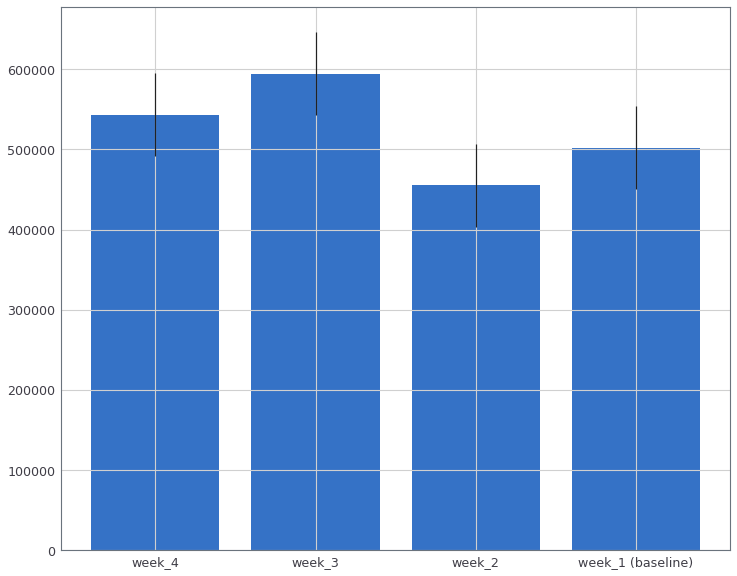

In [66]:
plt.xticks(np.arange(4), ('week_4', 'week_3', 'week_2', 'week_1 (baseline)'))
predictions = np.array([model.best_score['week_4']['feval'], model.best_score['week_3']
                 ['feval'], model.best_score['week_2']['feval'], baseline])
plt.bar(np.arange(4), [model.best_score['week_4']['feval'], model.best_score['week_3']
                       ['feval'], model.best_score['week_2']['feval'], baseline], yerr=data.std())

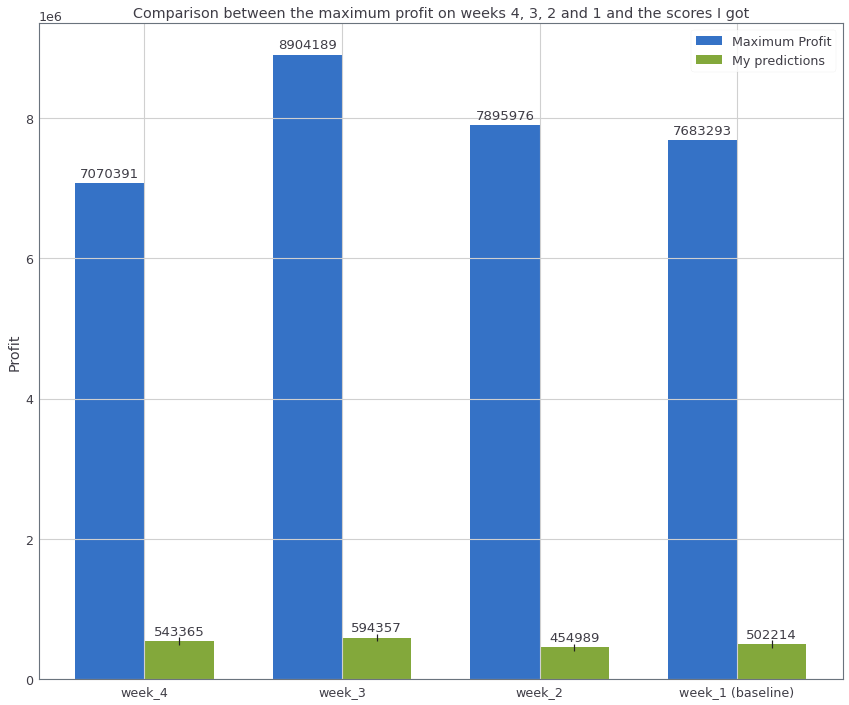

In [65]:
labels = ['week_4', 'week_3', 'week_2', 'week_1 (baseline)']
x = np.arange(len(max_profit))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width / 2,  max_profit, width, label='Maximum Profit')
rects2 = ax.bar(x + width / 2, predictions, width, label='My predictions', yerr=profit_std)
# rects2 = ax.bar(x + (3 * width/3), profit_std, width, label='Standard Deviation')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Profit')
ax.set_title('Comparison between the maximum profit on weeks 4, 3, 2 and 1 and the scores I got')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.0f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

In [84]:
all_weeks_profit = []
for i in range(13, 0, -1):
    curr_results = shifting.loc[shifting.group_backwards == i].orderSum.values
    all_weeks_profit.append(baseline_score(curr_results, curr_results, infos['simulationPrice']))
    print((f'week_{i}', all_weeks_profit[13 - i]))

('week_13', 3195415.3499999996)
('week_12', 3350567.0599999996)
('week_11', 3777793.67)
('week_10', 4579935.46)
('week_9', 6900105.6)
('week_8', 7185295.09)
('week_7', 7032292.539999999)
('week_6', 6951982.159999999)
('week_5', 7323267.24)
('week_4', 7070391.0)
('week_3', 8904189.42)
('week_2', 7895975.870000001)
('week_1', 7683293.24)


<BarContainer object of 13 artists>

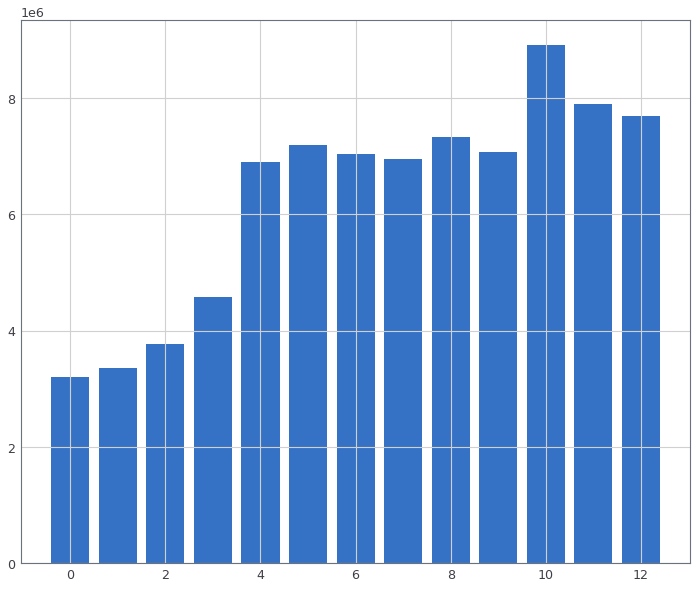

In [89]:
plt.bar(x=np.arange(len(all_weeks_profit)), height=all_weeks_profit)

In [96]:
profit_std/np.std(all_weeks_profit[-4:])

0.07784152217666815

<hr>

## Dataset Splitting (Retraining until week 2 and test with week 1)
All my experiments will use weeks 13 to 2 as a train set and week 1 as test

In [24]:
train = shifting.loc[shifting.group_backwards >= 2]
test = shifting.loc[shifting.group_backwards == 1]

weights = infos.set_index('itemID')['simulationPrice'].to_dict()

w_train = train['itemID'].map(weights)

In [25]:
# I recommend to the other members of the team keeping the
# datatypes of our datasets as Pandas DataFrames instead of Numpy,
# since It will easier to use Boosting Analysis frameworks
y_train = train['orderSum']
X_train = train.drop(columns=["orderSum"])

In [27]:

params = {
#           "objective" : "poisson",
          "objective" : "l1",
          "metric" :"rmse",
          "learning_rate" : 0.5,
          'verbosity': 1,
          'max_depth': 7,
          'num_leaves': 15,
          "min_data_in_leaf":3500,
         }

lgbtrain = lgb.Dataset(X_train, label = y_train, weight=w_train, categorical_feature=[2, 3, 5, 6, 7, 9])

model = lgb.train(params,
                  lgbtrain,
                  model.best_iteration,
                  valid_sets = [lgbtrain], 
                  valid_names = ['train'],
                  verbose_eval=5,
                  early_stopping_rounds=5,
#                   fobj=objective,
                  feval=feval,
                  
                 )

Training until validation scores don't improve for 5 rounds
[5]	train's rmse: 39.566	train's feval: 6.51117e+06
[10]	train's rmse: 39.1716	train's feval: 7.95597e+06
Did not meet early stopping. Best iteration is:
[10]	train's rmse: 39.1716	train's feval: 7.95597e+06


In [25]:
y_test = test['orderSum']
X_test = test.drop(columns=["orderSum"])
final_predictions = model.predict(X_test)

In [26]:
final_predictions

array([1.125, 0.   , 0.   , ..., 0.   , 0.5  , 0.5  ])

In [27]:
final_predictions[final_predictions < 0] = 0

In [28]:
final_predictions

array([1.125, 0.   , 0.   , ..., 0.   , 0.5  , 0.5  ])

In [29]:
baseline_score(final_predictions, y_test.values, infos['simulationPrice'])

502214.418

<hr>

### Utilities

**Predicting at test time**

# Post Processing (based on Bruno's 1.8 Notebook)

In [45]:
# Weekpair is negative, so this works:
first_fortnight_item = orders.sort_values("group_backwards",
                                     ascending=False)\
                          .groupby(["itemID"])["group_backwards"].first()

In [46]:
new_items_value = 10  # The mode seems too high, so go with 10...
idx = X_test["itemID"].isin(first_fortnight_item[first_fortnight_item == 1].index)
final_predictions[idx] = new_items_value

**Baseline calculation**

In [47]:
baseline_score(final_predictions, y_test.values, infos['simulationPrice'])

472166.99399999995